# Tutorial on using ScalarFDFD

## 1. Load package, procresses and module

First we want to add processes via `addprocs`. On my computer, with 8 threads, I'll add 7 (I wrap in an if block so that I don't accidentally do this over and over again). That means 1 thread will be the process this notebook is running from, and the other 7 can do work, perhaps even "in the background" if you so instruct.

To do this we must first load the `Distrubted` package by calling `using Distributed`

In [9]:
using Distributed
if nprocs() == 1; addprocs(7); end;

Next, run the `@startup` macro (defined in my ~/.julia/config/startup.jl file).
The relevant effect is that it loads the `Plots` package and sets the color theme to its argument, or to `default` if none is provided.

Alternatively, one may simply ignore this altogether, it's not necessary for ScalarFDFD.

If you don't use it, then you must explicitly call `using Plots` before attempting to plot anything.

In [10]:
@startup :default

First, activate the ScalarFDFD environment so that the package can be loaded. Wherever you've put the ScalarFDFD folder, just give it that path.

Because this path is not yet registered (it may never be), one must instruct all the processes about the existence of ScalarFDFD. To do this call the following lines, replacing the argument to `activate` will the path to wherever you put the ScalarFDFD folder on your computer.

In [11]:
@everywhere using Pkg: activate
@everywhere activate("/Users/wrs/wrs julia/ScalarFDFD")

Load the ScalarFDFD module on all processes:

In [12]:
@everywhere using ScalarFDFD

┌ Info: Recompiling stale cache file /Users/wrs/.julia/compiled/v1.0/ScalarFDFD/2eHXo.ji for ScalarFDFD [1501fb56-d95b-11e8-28b3-6dc6380aac00]
└ @ Base loading.jl:1187


## 2. Your first simulation: square lattice pc crossed waveguides

### 2a. Building your first simulation

The object that stores all the simulation parameters is a Simulation object. We will build it in stages.

The computational region is $\Omega$, so the boundary is $\partial\Omega$. We specify the boundary conditions with `bc`, the boundary layers with `bl`, and the boundary layer thickness with `bl_depth`.

Finally we construct the boundary object with a call to `Boundary`

In [5]:
∂Ω = [-8  -8    # [x_min   y_min
       9  9]    #  x_max   y_max]

bc = :d         # boundary condition (in this case Dirichlet), if scalar applies to all sides, else specify as matrix as above
bl = :pml       # boundary layer (in this case PML)
bl_depth = 3    # boundary layer depth

bnd = Boundary(∂Ω=∂Ω, bc=bc, bl=bl, bl_depth=bl_depth)    # boundary object

Boundary: 
		-------------------------
	bound.	|	   :d    	|
	cond-	|   :d    	   :d   |
	 ition	|	   :d    	|
		-------------------------
		|	+9.000		|
	∂Ω	| -8.000	+9.000	|
		|	-8.000		|
		-------------------------
		|	+6.000		|
	∂Ω_tr	| -5.000	+6.000	|
		|	-5.000		|
		-------------------------
	bound.	|	:pml_out	|
	layer	|:pml_out	:pml_out|
		|	:pml_out	|
		-------------------------
	bound.	|	+3.000		|
	layer	| +3.000	+3.000	|
	depth	|	+3.000		|
		-------------------------


Now build the computational lattice, with lattice spacing `dx` 

In [6]:
dx = .05
dis = Discretization(dx)

Discretization: 
	N: [1, 1]
	sub-pixel number: 20
	dx: [0.05, 0.05]

Now the fun part, building the interior of the computational domain.
Here our goal is to build crossed photonic crystal waveguides.

First defince a photonic crystal lattice `lat` with a call to `Bravais`:

In [7]:
lat = Bravais(a=1, b=1)

Bravais: 
	primitive vector 1: 1.00, ∠0.00°
	primitive vector 2: 1.00, ∠90.00°
	origin: (0.00, 0.00)

This defines a square lattice. Let's initialize a domain object with a call to `build_pc_domain`

In [8]:
pc = build_pc_domain(lat)

Domain: 
	Domain type: pc
	domain function: ScalarFDFD.whole_domain
	domain params: []
	domain lattice: 
		primitive vector 1: 1.00, ∠0.00°
		primitive vector 2: 1.00, ∠90.00°
		origin: (0.00, 0.00)
	background Re{n}: 1.0
	background Im{n}: 0.0
	background F: 0.0
	Re{n} by region: []
	Im{n} by region: []
	F by region: []
	region functions: []
	region params: []

There's a lot of information in that printout, but at the moment most of it isn't helpful.

Now we get to add structure to the unit cell. We will add two pillars, each with index $n=3$.

One will have radius $R=.1$, located $(.3,.3)$ from the lower left-hand portion of the unit cell, while the other will have $R=.2$ at $(.7,.7)$.

In [9]:
pc = add_circle_to_pc(pc, :sw; R=.1, n₁ = 3, x0=.3, y0=.3)
pc = add_circle_to_pc(pc, :sw; R=.20, n₁ = 3, x0=.7, y0=.7)

Domain: 
	Domain type: pc
	domain function: ScalarFDFD.whole_domain
	domain params: []
	domain lattice: 
		primitive vector 1: 1.00, ∠0.00°
		primitive vector 2: 1.00, ∠90.00°
		origin: (0.00, 0.00)
	background Re{n}: 1.0
	background Im{n}: 0.0
	background F: 0.0
	Re{n} by region: [3.0, 3.0]
	Im{n} by region: [0.0, 0.0]
	F by region: [0.0, 0.0]
	region functions: [circle_region, circle_region]
	region params: [[0.7, 0.7, 0.2], [0.3, 0.3, 0.1]]

Compare this printout to that from the initialization of `pc` to see that we've added some structure to the interior. To package this all up we make a call to `System`:

In [10]:
sys = System(pc)

System with 1 domains: 
	domain 1 type: pc


Right now we've constructed a superlattice (a $1\times1$ unit cell tiled over a $17\times17$ domain).

Next we want to add waveguides: the first will be vertical, and the second horizontal.

In [11]:
sys = add_pc_waveguide(sys; width=1, direction=:horizontal)
sys = add_pc_waveguide(sys; width=1, direction=:vertical)

System with 11 domains: 
	domain 1 type: pc_waveguide, bottom, waveguide 3
	domain 2 type: pc_waveguide, top, waveguide 4
	domain 3 type: pc_waveguide, left, waveguide 1
	domain 4 type: pc_waveguide, right, waveguide 2
	domain 5 type: pc_waveguide_background, bottom, waveguide 3
	domain 6 type: pc_waveguide_background, top, waveguide 4
	domain 7 type: pc_waveguide_background, left, waveguide 1
	domain 8 type: pc_waveguide_background, right, waveguide 2
	domain 9 type: bulk_pc_waveguide_y
	domain 10 type: bulk_pc_waveguide_x
	domain 11 type: pc

	waveguide 1 domains: [3, 7]
	waveguide 2 domains: [4, 8]
	waveguide 3 domains: [1, 5]
	waveguide 4 domains: [2, 6]



Notice that each asymptotic region defines its own waveguide, though the asymptotic regions can be joined by a bulk waveguide in the simulated domain, as is the case with, say, waveguides 1 & 2.

Since we are going to do a scattering calculation in this example, we need to define what our channels are. This is done by calls to `Channels`, with the first argument a reference to which waveguide the channel lives in, and the second argument is which quantum number to associate with that channel (in this case, the quantum number is the transverse mode number).

Here we will define channels to be coming from the bottom and coming from the left, both in the fundamental mode.

In [12]:
chn1 = Channels(1,1)
chn2 = Channels(3,1)
sct = Scattering(chn1,chn2)

Scattering with 2 channels:
	Channel 1:
		waveguide: 1
		quantum number: 1
	Channel 2:
		waveguide: 3
		quantum number: 1

Finally we are ready to put the whole simulation together into a neat package!

The flag `disp_opt` gives us some information about what the simulation construction is spending its time on. By default it is set to `false`, but here we are just showing what exists!

In [13]:
sim1 = Simulation(;sys=sys, bnd=bnd, dis=dis, sct=sct, disp_opt=true)

sub-pixel smoothing 100%|███████████████████████████████| Time: 0:00:04
sub-pixel smoothing 100%|███████████████████████████████| Time: 0:00:03
sub-pixel smoothing 100%|███████████████████████████████| Time: 0:00:03


Simulation: 

sys: 	domain 1 type: pc_waveguide, bottom, waveguide 3
	domain 2 type: pc_waveguide, top, waveguide 4
	domain 3 type: pc_waveguide, left, waveguide 1
	domain 4 type: pc_waveguide, right, waveguide 2
	domain 5 type: pc_waveguide_background, bottom, waveguide 3
	domain 6 type: pc_waveguide_background, top, waveguide 4
	domain 7 type: pc_waveguide_background, left, waveguide 1
	domain 8 type: pc_waveguide_background, right, waveguide 2
	domain 9 type: bulk_pc_waveguide_y
	domain 10 type: bulk_pc_waveguide_x
	domain 11 type: pc

	waveguide 1 domains: [3, 7]
	waveguide 2 domains: [4, 8]
	waveguide 3 domains: [1, 5]
	waveguide 4 domains: [2, 6]



bnd: 		-------------------------
	bound.	|	   :d    	|
	cond-	|   :d    	   :d   |
	 ition	|	   :d    	|
		-------------------------
		|	+9.000		|
	∂Ω	| -8.000	+9.000	|
		|	-8.000		|
		-------------------------
		|	+6.000		|
	∂Ω_tr	| -5.000	+6.000	|
		|	-5.000		|
		-------------------------
	bound.	|	:pml_out	|
	layer	|:pml_out	:pml_o

To visualize what we just made, simply

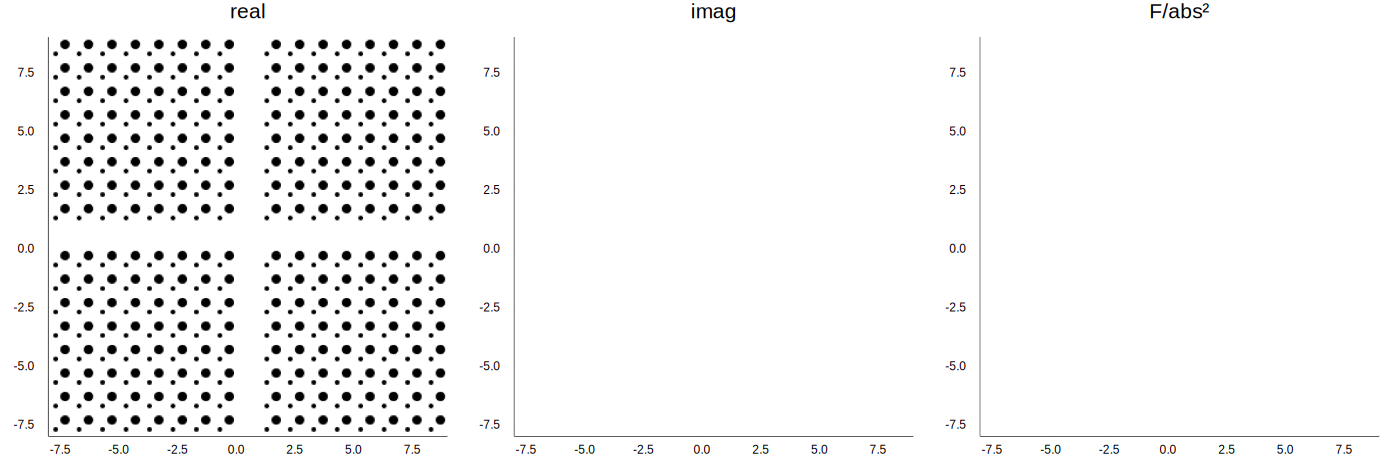

In [14]:
p = plot(sim1)

and save the result via

In [15]:
savefig(p, "test1/pc_sim1.pdf")

### 2b. Band Structure

Let's see what frequencies we should be operating at by looking at the band structure is.

Note we specify `parallel` to be true, but in face it defaults to checking whether multiple processes are active and responding accordingly.

Here we are setting the `zone` to 1, which means the lower quarter of the full Brillouin Zone. We could have specified an arry of zones, or one of `:reduced`, `:half`, or `:full`.

`:reduced` sort of does what it says it does, it's just have of zone 1, which is not quite the same as the irreducible BZ. That's a future development. It should do just about as good a job getting the band gaps, though.
`:full` takes a bunch of paths across each zone, and `:half` just does it for zones 1 and 2.

Note that in a Hermitian cell, zones 1 and 4, and separately zones 2 and 3 are equivalent (up to a reflection), so generally `:full` is redundant. If there is further symmetry within the cell, then zone 1 or `:reduced` will be sufficient.

In [16]:
bands1, gaps1 = band_structure(sim1; waveguide=1, zone=1, parallel=true);

waveguide band structure 100%|██████████████████████████| Time: 0:00:27


Plot and save the result.

All relevant plots are easiest if the first argument is the simulation.

The order and number of the rest don't really matter.

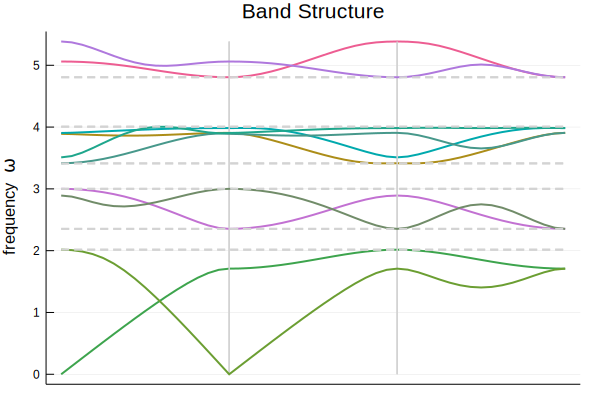

In [20]:
p = plot(sim1, gaps1, bands1, lw=2)
savefig(p, "test1/pc_band_structure1.pdf")
p

### 2c. Dispersion

Build the dispersion curves for each waveguide. This is not necessary to do explicitly, as the first time it is needed for a scattering calculation it checks to see if it has already been done, and, if not, it does it and save the result to `sim`. But doing it this way allows much more control, though we are not using that here.

In [21]:
build_dispersions!(sim1)

Building dispersion for waveguide 1


waveguide band structure 100%|██████████████████████████| Time: 0:00:00
waveguide dispersion 100%|██████████████████████████████| Time: 0:00:03


Building dispersion for waveguide 3


waveguide band structure 100%|██████████████████████████| Time: 0:00:00
waveguide dispersion 100%|██████████████████████████████| Time: 0:00:03


To take a look at the dispersion curve, we just

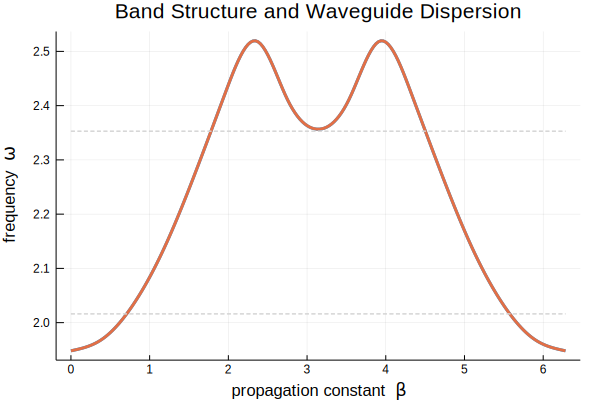

In [22]:
p = plot(sim1, sim1.sct)
savefig(p, "test1/pc_wg_dispersion1.pdf")
p

though `plot(sim,sim)` would have done just the same.

### 2d. Scattering

All this tells us that we can meaningfully expect to do a scattering calculation, are ω=2.2 (say)

In [23]:
ψ1_sct, ψ1_tot = scattering(sim1, 2.2, [1,1]);

the third argument is an array of amplitudes (one for each channel)

let's look at the result!

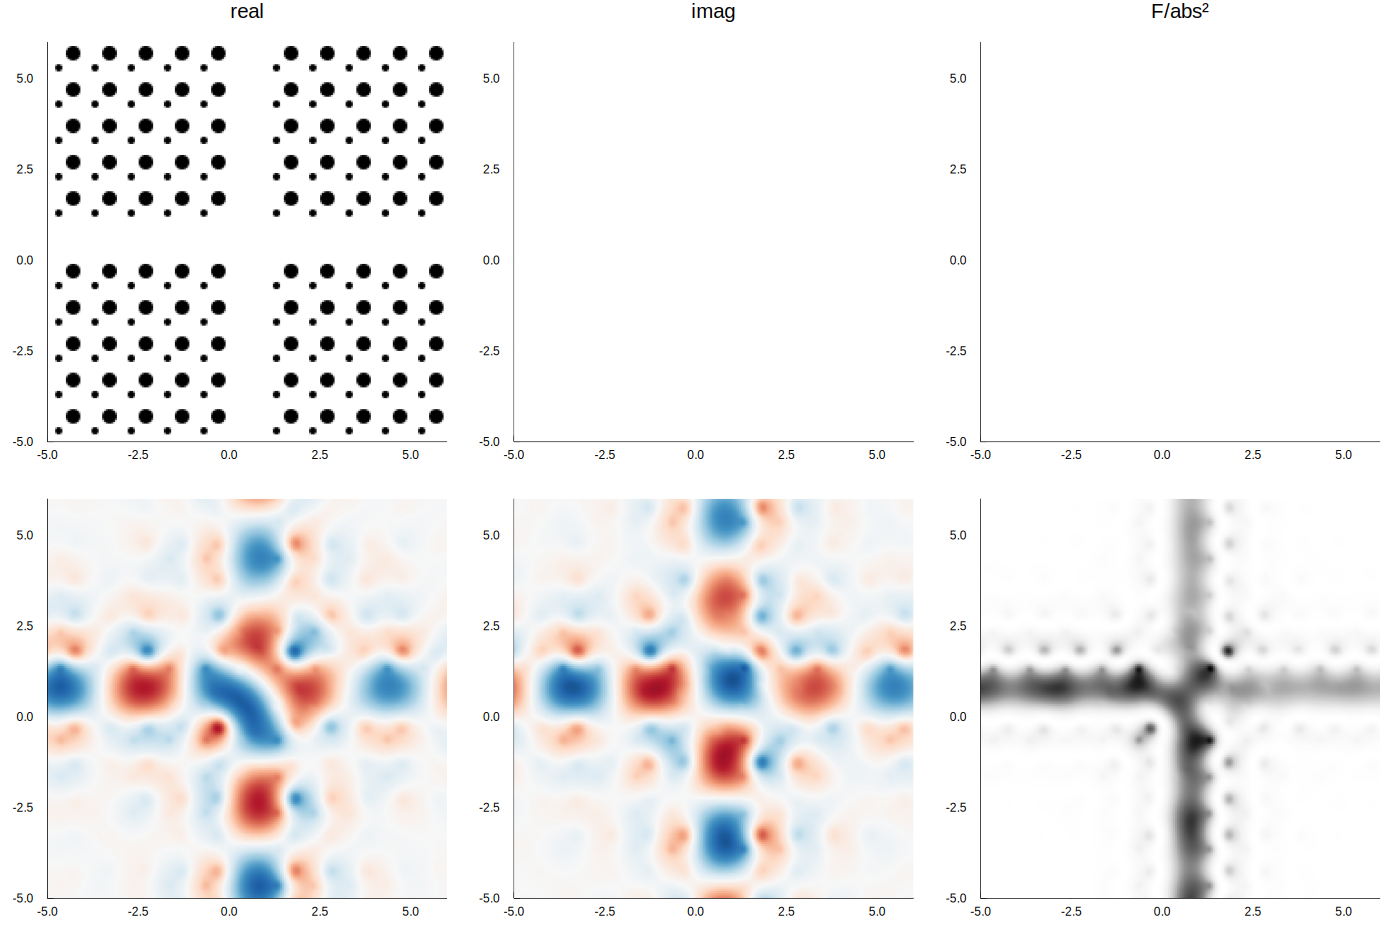

In [24]:
p = plot(sim1, ψ1_tot);
savefig(p, "test1/pc_scattering1.pdf");
p

and make a cool animation

In [25]:
animate(wave(sim1, ψ1_tot, by=real), size=(500,500), "test1/pc_scattering1.gif")

┌ Info: Saved animation to 
│   fn = /Users/wrs/wrs julia/ScalarFDFD/tests/test1/pc_scattering1.gif
└ @ Plots /Users/wrs/.julia/packages/Plots/rmogG/src/animation.jl:90


Plots.AnimatedGif("/Users/wrs/wrs julia/ScalarFDFD/tests/test1/pc_scattering1.gif")

which sadly won't show in Jupyterlab, but does in Jupyter Notebooks.

Note that plot attributes can be fed as optional keyword arguments to `animate`.

The only additional arguments fed to `wave` are `by`, which is the function used to plot $\psi$, and `truncate`, which defaults to `true`, and determines whether to include the boundary layer in the plot (defaulting to `false`).

## 3. Second example: hexagonal pc waveguide terminating in bulk

### 3a. Simulation construction

let's do another example, this time with a lot fewer comments.

We'll look at a terminated waveguide in a hexagonal photonic crystal.

In [100]:
∂Ω = [-9  -6*sqrt(3)/2
       10  6*sqrt(3)/2];

Note that for the time being, we must manually enforce that the overall domain is commensurate with the unit cells (in particular for this example the height must be an integer multiple of $\sqrt{3a/4}$).

Automatic implementation of this is something I hope to include in the future.

In [101]:
bc = :d
bl = [:pml :none
      :abs :none]
   
bl_depth = 4
bnd = Boundary(∂Ω=∂Ω, bc=bc, bl=bl, bl_depth=bl_depth)

dx = .05
dis = Discretization(dx);

┌ Warning: boundary layer [1,2] set to :none, but has thickness 4 > 0
│         setting bl_depth[1,2] = 0
└ @ ScalarFDFD /Users/wrs/wrs julia/ScalarFDFD/src/definitions.jl:290
┌ Warning: boundary layer [2,2] set to :none, but has thickness 4 > 0
│         setting bl_depth[2,2] = 0
└ @ ScalarFDFD /Users/wrs/wrs julia/ScalarFDFD/src/definitions.jl:290


this time we use the slightly more appropriate absorbing boundary layer for photonic crystals, but it must be longer (I think?)

This time we specify the angle of the second primitive vector. This choice corresponds to a hexagonal lattice.

Also, did you notice the nifty error-catching and concommitant warning?

In [102]:
pc = build_pc_domain(Bravais(a=1, b=1, β=π/3), Regions(), n₁ = sqrt(1));

add a pillar to the middle of the cell

In [103]:
pc = add_circle_to_pc(pc, :center; R=.2, n₁ = 2);
sys = System(pc);

Add a waveguide, this time it will terminate in the bulk

In [104]:
sys = add_pc_waveguide(sys; width=1, direction=:west)

System with 4 domains: 
	domain 1 type: pc_waveguide, left, waveguide 1
	domain 2 type: pc_waveguide_background, left, waveguide 1
	domain 3 type: bulk_pc_waveguide_x
	domain 4 type: pc

	waveguide 1 domains: [1, 2]



Now we add one channel for scattering, and build the simulation

sub-pixel smoothing 100%|███████████████████████████████| Time: 0:00:02
sub-pixel smoothing 100%|███████████████████████████████| Time: 0:00:02


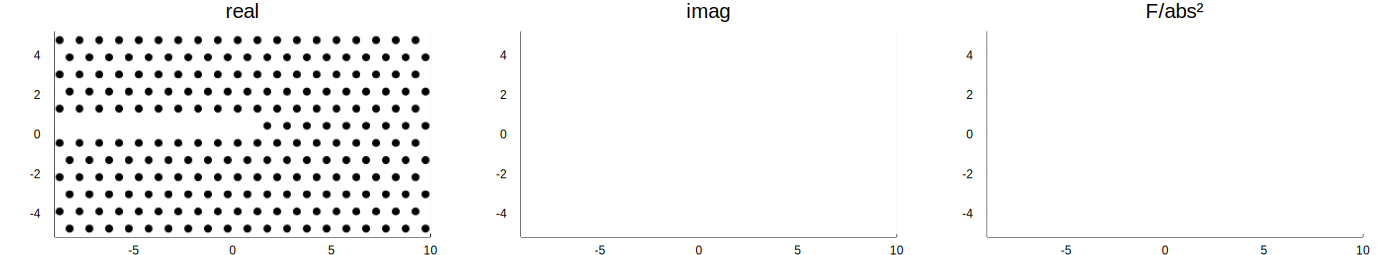

In [105]:
sct = Scattering([Channels(1,1)])

sim2 = Simulation(;sys=sys, bnd=bnd, dis=dis, sct=sct, disp_opt=true)

p = plot(sim2); savefig(p,"test2/pc_sim2.pdf");
p

Note there is one sub-pixel smoothing run for each waveguide.

### 3b. Band Structure

This time let's map out the whole surface, but over the "reduced" zone (sort of) (by making num_bloch an array instead of a number)

In [106]:
bands2, gaps2 = band_structure(sim2; waveguide=1, num_bloch=[21], zone=:reduced);

waveguide band structure 100%|██████████████████████████| Time: 0:00:01


same plotting command as before now plots the whole surface!

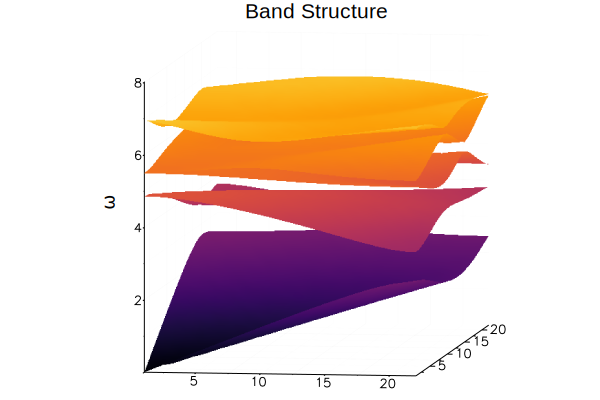

In [107]:
p = plot(sim2, bands2, gaps2; camera=(15,20));
savefig(p,"test2/pc_band_structure2.pdf")
p

The camera argument sets the viewpoint. It's not at all necessary.

Just because we can, let's also look at the band structure mapped over the boundaries of the reduced zone

This time I'm going to specify the path we take in reciprocal space. The second argumet to `band_structure` is a tuple of arrays of points in the reciprocal basis `([kx's], [ky's])`. The third argument is an integer specifying how many points on each leg (including the end points). For now the corners are double counted, will eventually fix that in the future.

Anyway we are now going to specify the boundary of the irreducible BZ, with 21 points on each leg.

band structure 100%|████████████████████████████████████| Time: 0:00:00


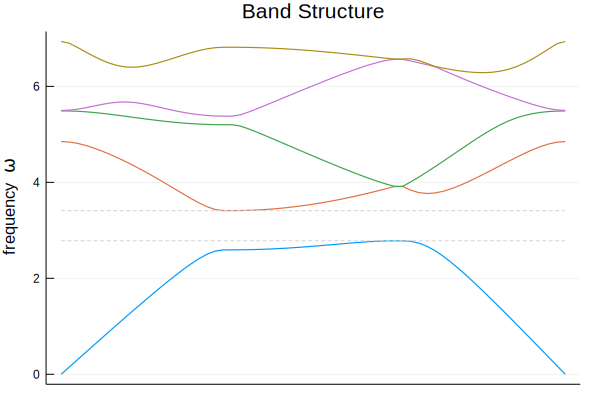

In [108]:
bands2, gaps2 = band_structure(sim, ([0, 1/2, 2/3, 0],[0, 0, 1/3, 0]), 21);
p = plot(sim2, bands2, gaps2)
savefig(p, "test2/pc_band_structure2_alt.pdf")
p

We see there is a gap around 3. So let's venture a guess and scatter at ω = 3.0
note this time we are not explicitly building the dispersion curves, as this
is done during the scattering calculation. we can check after to see if our
guess was a safe one

In [109]:
ψ2_sct, ψ2_tot = scattering(sim2, 3, [1]);

Building dispersion for waveguide 1


waveguide band structure 100%|██████████████████████████| Time: 0:00:00
waveguide dispersion 100%|██████████████████████████████| Time: 0:00:01


Note that this time we did not call `build_dispersions!` first, because we are leaving it to happen in `scattering`

Let's check the dispersion by calling `plot` with two Simulation arguments (the second is the one whose dispersion will be plotted, but there's no reason to make the two different really.

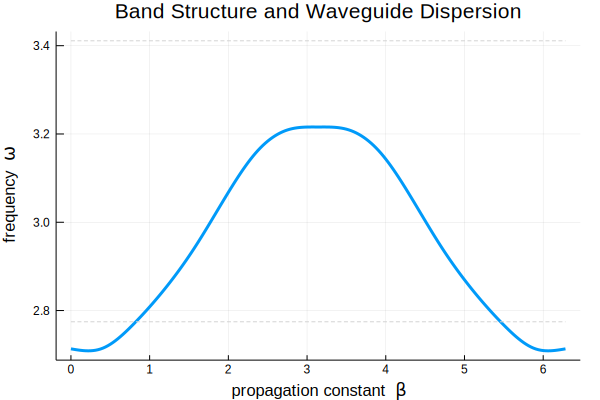

In [110]:
plot(sim2,sim2)

Indeed 3.1 was a good choice for frequency.

let's look at the scattering result:

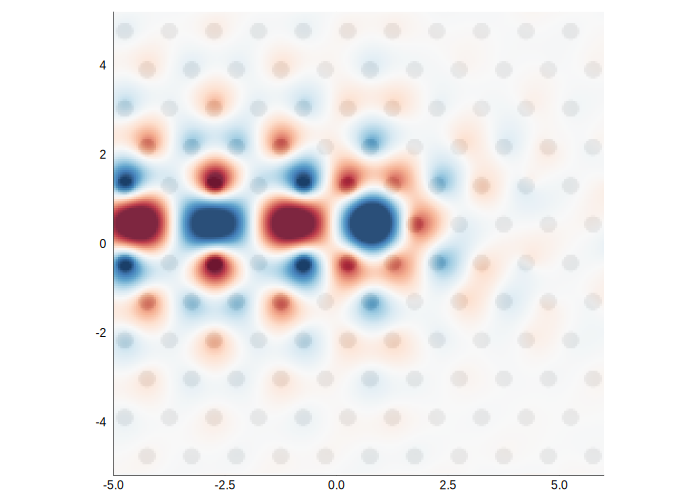

In [111]:
p = plot(sim2, ψ2_tot, by=imag, size=(700,500));
savefig(p, "test2/pc_scattering2.pdf")
p

Looks pretty good!

Perhaps you don't like that color scheme? Or some other parameters?

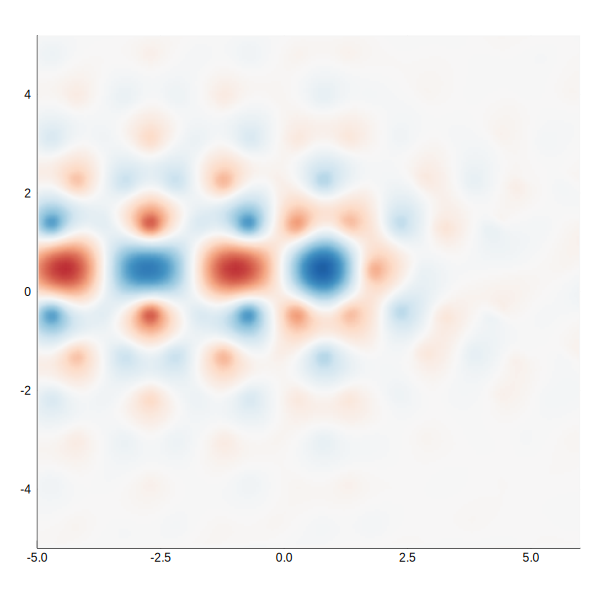

In [134]:
p = plot(sim2, ψ2_tot, by=imag, seriestype=:contourf, size=(600,600), clims=(-2,2), seriesalpha=1);
savefig(p, "test2/pc_scattering2_alt.pdf")
p

and let's make a movie, but with contours this time

In [298]:
animate(wave(sim2, ψ2_tot; by=real), seriestype=:contour, levels=30, clims=(-2,2),
    "test2/pc_scattering2.gif", size=(400,400))

┌ Info: Saved animation to 
│   fn = /Users/wrs/wrs julia/ScalarFDFD/tests/test2/pc_scattering2.gif
└ @ Plots /Users/wrs/.julia/packages/Plots/rmogG/src/animation.jl:90


Plots.AnimatedGif("/Users/wrs/wrs julia/ScalarFDFD/tests/test2/pc_scattering2.gif")

## 4. Corner in Square Lattice: eigen-problem and scattering problem

I'll keep the commentary to a minimum this time. Note I don't specify `bc` because it defaults to dirichlet

In [21]:
∂Ω = [-8  -6
       7   9]

bl = [:pml_in  :abs
      :abs     :abs_out]

bl_depth = [5  3
            3  5]
bnd = Boundary(∂Ω=∂Ω, bl=bl, bl_depth=bl_depth)

dx = .04
dis = Discretization(dx)

pc = build_pc_domain(Bravais(a=1, b=1), Regions())
pc = add_circle_to_pc(pc, :center; R=.2, n₁ = 3)

sys = System(pc)
sys = add_pc_waveguide(sys; width=1, direction=:west)
sys = add_pc_waveguide(sys; width=1, direction=:north)


sct = Scattering([Channels(1,1)])

sim3 = Simulation(;sys=sys, bnd=bnd, dis=dis, sct=sct);

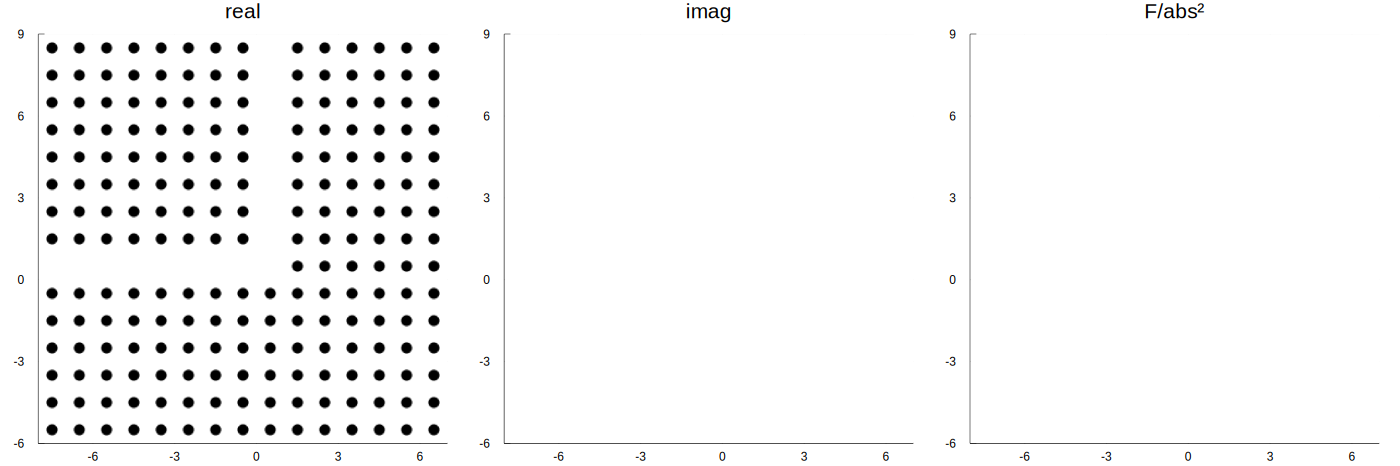

In [22]:
p = plot(sim3);
savefig("test3/pc_sim3.pdf")
p

waveguide band structure 100%|██████████████████████████| Time: 0:00:01


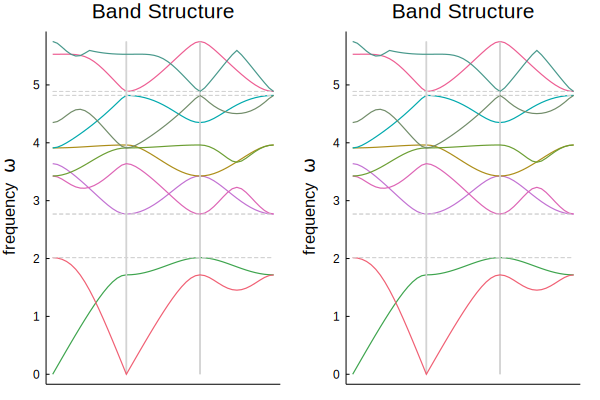

In [23]:
bands3, gaps3 = band_structure(sim3; waveguide=1)

p = plot(sim3, bands3, gaps3);
savefig("test3/pc_band_structure3.pdf")
p

This was over zones 1 & 2 by default. Can be specified with `zone` optional argument to `band structure`

### 4a. Unidirectional Eigenvalue Problem

`eig_k` is a wrapper that does most of the work for us.

Here, the second argument is the frequency to search near. The third argument is the number of modes you want.

In [24]:
k3, ψ3 = eig_k(sim3, 2.6, 2)
k3

2-element Array{Complex{Float64},1}:
 2.528300917478777 - 0.13990509486046776im
 2.517724282037235 + 0.14264680783923067im

i don't know why these aren't closer to being conjugates of each other. I'll work on it in the future.

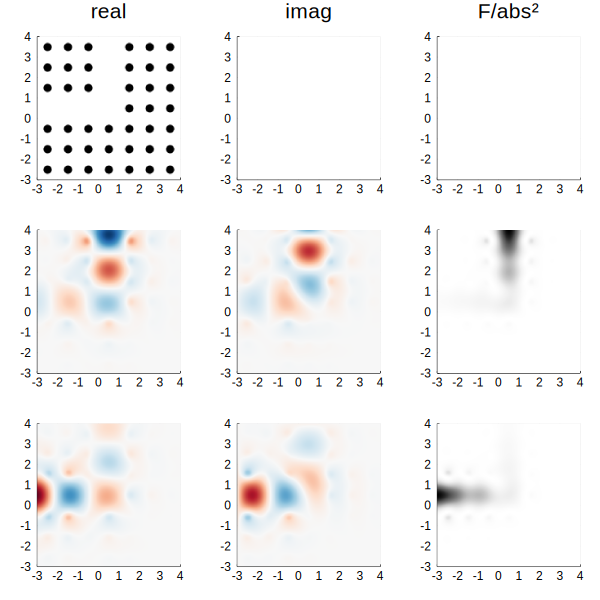

In [25]:
p = plot(sim3,ψ3, size=(600,600));
savefig("test3/pc_uni_eig3.pdf");
p

In [ ]:
animate(wave(sim3, ψ3; by=real, truncate=true), size=(600,600),
    clims=(-.45,.45), seriesalpha=.7, "test3/pc_scattering3.gif")

In [ ]:
ψ3_sct, ψ3_tot = scattering(sim3, 2.5, [1]);

In [ ]:
animate(wave(sim3, ψ3_tot; by=real, truncate=false), size=(600,600),
    clims=(-.45,.45), seriesalpha=.7, "test3/pc_scattering3a.gif", seriestype=:contour)